In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Text
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Capture similarity 
from sentence_transformers import SentenceTransformer



In [109]:
%%time
stocks = pd.read_csv('sp500.csv')

CPU times: total: 15.6 ms
Wall time: 13.1 ms


In [110]:
print(stocks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   idnumber             493 non-null    int64  
 1   exchange             493 non-null    object 
 2   symbol               493 non-null    object 
 3   shortname            493 non-null    object 
 4   longname             493 non-null    object 
 5   longnamesort         493 non-null    object 
 6   sector               493 non-null    object 
 7   industry             493 non-null    object 
 8   prices               493 non-null    float64
 9   marketcap            493 non-null    float64
 10  ebitda               463 non-null    float64
 11  revenuegrowth        492 non-null    float64
 12  city                 493 non-null    object 
 13  state                474 non-null    object 
 14  country              493 non-null    object 
 15  fulltimeemployees    486 non-null    flo

In [111]:
stocks.drop(['longnamesort','prices','esgrating','logo'], inplace=True, axis=1)

In [112]:
print(stocks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   idnumber             493 non-null    int64  
 1   exchange             493 non-null    object 
 2   symbol               493 non-null    object 
 3   shortname            493 non-null    object 
 4   longname             493 non-null    object 
 5   sector               493 non-null    object 
 6   industry             493 non-null    object 
 7   marketcap            493 non-null    float64
 8   ebitda               463 non-null    float64
 9   revenuegrowth        492 non-null    float64
 10  city                 493 non-null    object 
 11  state                474 non-null    object 
 12  country              493 non-null    object 
 13  fulltimeemployees    486 non-null    float64
 14  longbusinesssummary  493 non-null    object 
 15  weight               493 non-null    flo

Sector Distribution

<AxesSubplot:>

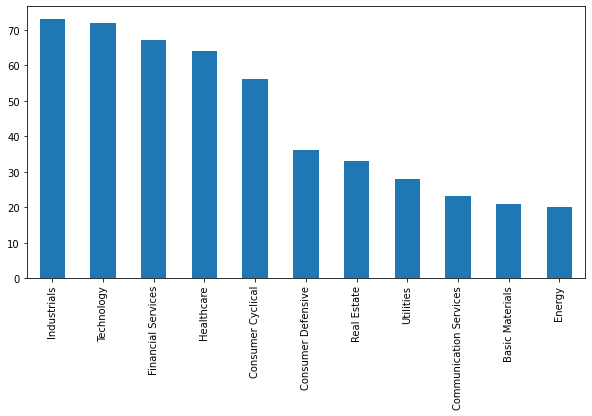

In [113]:
stocks['sector'].value_counts().plot(x = 'sector', y ='count', kind = 'bar', figsize = (10,5))

Industry Distribution

<AxesSubplot:>

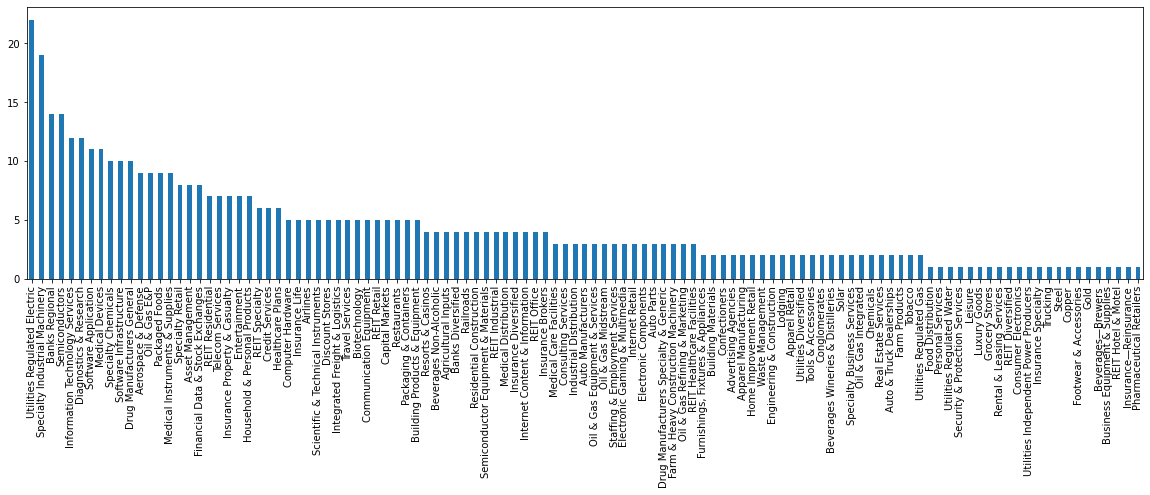

In [114]:
stocks['industry'].value_counts().plot(x = 'industry', y ='count', kind = 'bar', figsize = (20,5))

Exchange Distribution

<AxesSubplot:>

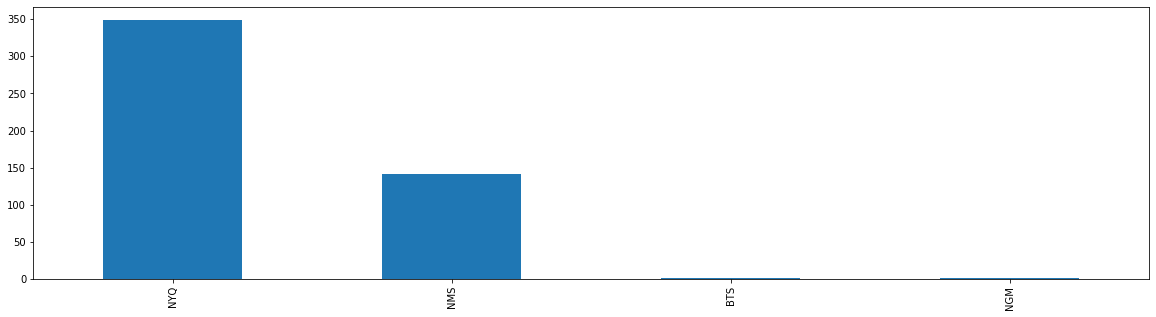

In [115]:
stocks['exchange'].value_counts().plot(x = 'exchange', y ='count', kind = 'bar', figsize = (20,5))

In [116]:
X = np.array(stocks.longbusinesssummary)

In [117]:
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [118]:
embed_data = embeddings

In [119]:
X = np.array(embed_data)
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()

,0,1,2,3,4
0,-1.094548,-3.025234,1.445609,-0.679056,-0.555069
1,-1.318473,-1.289029,-2.584330,-1.628621,3.127623
2,-2.478818,-1.561215,-4.145483,-0.558118,2.921716
3,-2.174770,-1.666618,-3.896361,0.295014,3.529516
4,-4.333915,0.252645,2.797494,1.588198,1.798529


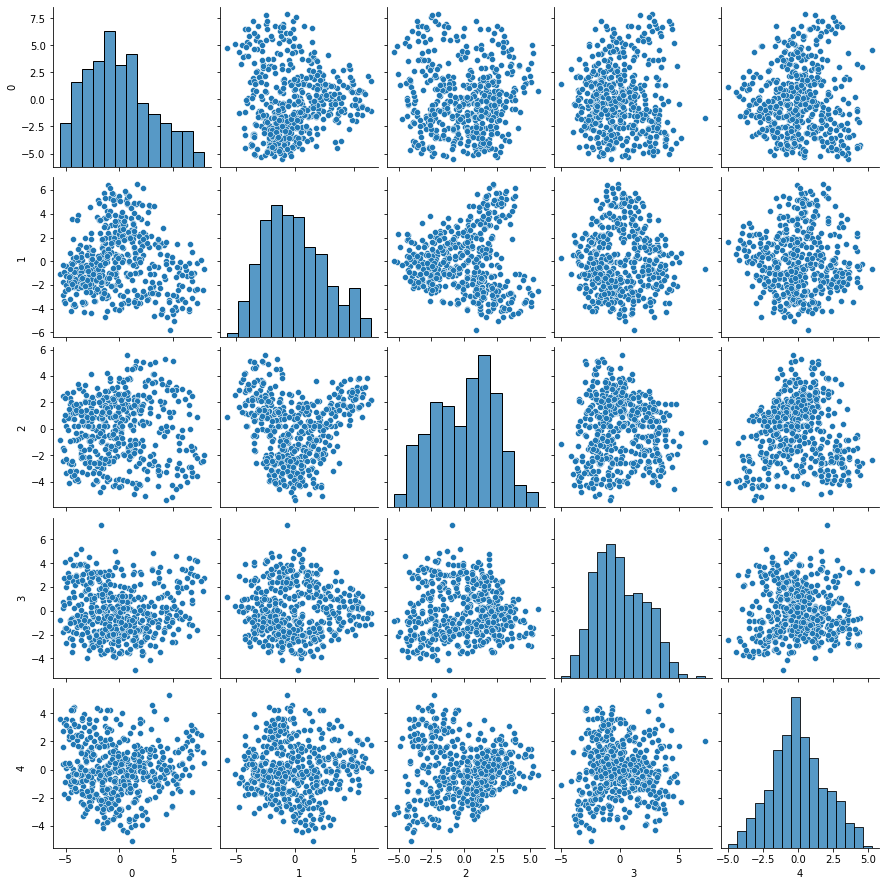

In [120]:
sns.pairplot(pca_data)

Recommender function taken in modified form from:https://towardsdatascience.com/hands-on-content-based-recommender-system-using-python-1d643bf314e4

In [121]:
cos_sim_data = pd.DataFrame(cosine_similarity(X))


def give_recommendations(index, print_recommendation=False, print_recommendation_plots=False, print_genres=False):
    index_recomm = cos_sim_data.loc[index].sort_values(
        ascending=False).index.tolist()[1:6]
    stocks_recomm = stocks['symbol'].loc[index_recomm].values
    result = {'Stocks': stocks_recomm, 'Index': index_recomm}
    if print_recommendation == True:
        print('The watched stock is this one: %s \n' %(stocks['symbol'].loc[index]))
        k = 1
        for stock in stocks_recomm:
            print('The number %i recommended stock is this one: %s \n' %(k, stock))
    if print_recommendation_plots == True:
        print('The longbusinesssummary of the watched stock is this one:\n %s \n' %(stocks['longbusinesssummary'].loc[index]))
        k = 1
        for q in range(len(stocks_recomm)):
            plot_q = stocks['longbusinesssummary'].loc[index_recomm[q]]
            print('The longbusinesssummary of the number %i recommended stock is this one:\n %s \n' % (
                k, plot_q))
            k = k+1
    if print_genres == True:
        print('The sector of the watched stock is this one:\n %s \n' %
              (stocks['sector'].loc[index]))
        k = 1
        for q in range(len(stocks_recomm)):
            plot_q = stocks['sector'].loc[index_recomm[q]]
            print('The sector of the number %i recommended stock is this one:\n %s \n' % (
                k, plot_q))
            k = k+1
    return result

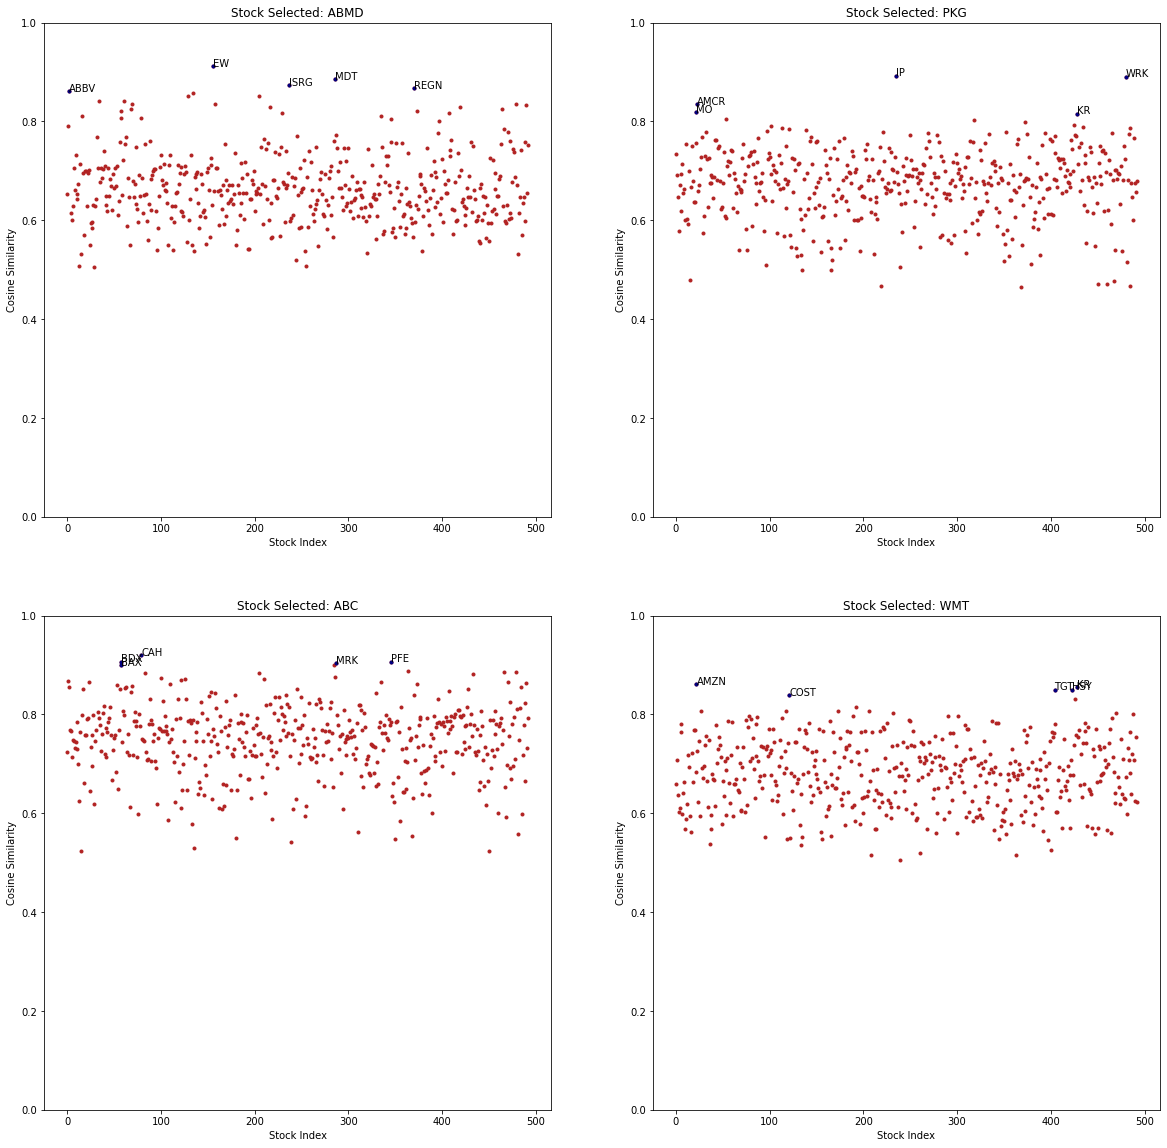

In [122]:
plt.figure(figsize=(20,20))
for q in range(1,5):
  plt.subplot(2,2,q)
  index = np.random.choice(np.arange(0,len(X)))
  to_plot_data = cos_sim_data.drop(index,axis=1)
  plt.plot(to_plot_data.loc[index],'.',color='firebrick')
  recomm_index = give_recommendations(index)
  x = recomm_index['Index']
  y = cos_sim_data.loc[index][x].tolist()
  m = recomm_index['Stocks']
  plt.plot(x,y,'.',color='navy',label='Recommended Stocks')
  plt.title('Stock Selected: '+stocks['symbol'].loc[index])
  plt.xlabel('Stock Index')
  k=0
  for x_i in x:
    plt.annotate('%s'%(m[k]),(x_i,y[k]),fontsize=10)
    k=k+1

  plt.ylabel('Cosine Similarity')
  plt.ylim(0,1)

In [123]:
give_recommendations(6,True, True, True)

The watched stock is this one: ADBE 

The number 1 recommended stock is this one: MSFT 

The number 1 recommended stock is this one: HPQ 

The number 1 recommended stock is this one: CDW 

The number 1 recommended stock is this one: IT 

The number 1 recommended stock is this one: VRSK 

The longbusinesssummary of the watched stock is this one:
 Adobe Inc. operates as a diversified software company worldwide. It operates through three segments: Digital Media, Digital Experience, and Publishing and Advertising. The Digital Media segment offers products, services, and solutions that enable individuals, teams, and enterprises to create, publish, and promote content; and Document Cloud, a unified cloud-based document services platform. Its flagship product is Creative Cloud, a subscription service that allows members to access its creative products. This segment serves content creators, workers, marketers, educators, enthusiasts, communicators, and consumers. The Digital Experience segment

{'Stocks': array(['MSFT', 'HPQ', 'CDW', 'IT', 'VRSK'], dtype=object),
 'Index': [293, 221, 87, 198, 462]}

Record recommendation results into Pandas DF

In [126]:
recomm_list = []
for i in range(len(X)):
    recomm_i = give_recommendations(i)
    recomm_list.append(recomm_i['Stocks'])
recomm_data = pd.DataFrame(recomm_list, columns=[
                           'First Recommendation', 'Second Recommendation', 'Third Recommendation', 'Fourth Recommendation', 'Fifth Recommendation'])
recomm_data['Watched Stock'] = stocks['symbol']
recomm_data = recomm_data[['Watched Stock', 'First Recommendation', 'Second Recommendation',
                           'Third Recommendation', 'Fourth Recommendation', 'Fifth Recommendation']]


KeyError: "['Watched Stock'] not in index"